In [29]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D,
                                     AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
                                    )
from tensorflow.keras.models import Model, load_model
from resnets_utils import *
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow

%matplotlib inline
np.random.seed(1)
tf.random.set_seed(2)

In [5]:
def identity_block(X, f, filters, initializer=random_uniform):
    F1, F2, F3 = filters

    # save the input value
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=1, strides=(1,1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', kernel_initializer= initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=1, strides=(1,1), padding='valid', kernel_initializer= initializer(seed=0))(X)
    X = BatchNormalization(axis= 3)(X)

    # Final step
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [6]:
### you cannot edit this cell

tf.keras.backend.set_learning_phase(False)

np.random.seed(1)
tf.random.set_seed(2)
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3

X = np.concatenate((X1, X2, X3), axis = 0).astype(np.float32)

A3 = identity_block(X, f=2, filters=[4, 4, 3],
                   initializer=lambda seed=0:constant(value=1))
print('\033[1mWith training=False\033[0m\n')
A3np = A3.numpy()
print(np.around(A3.numpy()[:,(0,-1),:,:].mean(axis = 3), 5))
resume = A3np[:,(0,-1),:,:].mean(axis = 3)
print(resume[1, 1, 0])

tf.keras.backend.set_learning_phase(True)

print('\n\033[1mWith training=True\033[0m\n')
np.random.seed(1)
tf.random.set_seed(2)
A4 = identity_block(X, f=2, filters=[3, 3, 3],
                   initializer=lambda seed=0:constant(value=1))
print(np.around(A4.numpy()[:,(0,-1),:,:].mean(axis = 3), 5))

/usr/local/lib/python3.10/dist-packages/keras/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


With training=False

[[[  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]]

 [[192.99974 192.99974 192.99974  96.99986]
  [ 96.99986  96.99986  96.99986  48.99993]]

 [[578.9994  578.9994  578.9994  290.99963]
  [290.99963 290.99963 290.99963 146.99982]]]
96.999855

With training=True

[[[0.      0.      0.      0.     ]
  [0.      0.      0.      0.     ]]

 [[0.40733 0.40733 0.40733 0.40733]
  [0.40733 0.40733 0.40733 0.40733]]

 [[5.00012 5.00012 5.00012 3.25951]
  [3.25951 3.25951 3.25951 2.40733]]]


In [7]:
def convolutional_block(X, f, filters, s=2, initializer=glorot_uniform):
    F1, F2, F3 = filters

    X_shortcut = X

    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters=F1, kernel_size=1, strides=(s,s), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)

    # SHORTCUT PATH
    X_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s), padding='valid', kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    # Final step
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [8]:
def ResNet50(input_shape=(64,64,3), classes=6, training=False):
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7,7), strides=(2, 2), kernel_initializer= glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2)

    X = identity_block(X, f=3, filters=[128, 128, 512])
    X = identity_block(X, f=3, filters=[128, 128, 512])
    X = identity_block(X, f=3, filters=[128, 128, 512])

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], s=2)

    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2)

    X = identity_block(X, f=3, filters=[512, 512, 2048])
    X = identity_block(X, f=3, filters=[512, 512, 2048])

    # AVGPOOL
    X = AveragePooling2D((2,2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer= glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [9]:
tf.keras.backend.set_learning_phase(True)

model = ResNet50(input_shape = (64, 64, 3), classes = 6)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 32, 32, 64)  256         ['conv2d_6[0][0]']               
 rmalization)                                                                                 

In [11]:
np.random.seed(1)
tf.random.set_seed(2)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00015)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [13]:
model.fit(X_train, Y_train, epochs = 10, batch_size = 32)

Epoch 1/10
34/34 [==============================] - 62s 156ms/step - loss: 1.8365 - accuracy: 0.3481
Epoch 2/10
34/34 [==============================] - 3s 87ms/step - loss: 1.0700 - accuracy: 0.5991
Epoch 3/10
34/34 [==============================] - 3s 86ms/step - loss: 0.5549 - accuracy: 0.8056
Epoch 4/10
34/34 [==============================] - 3s 87ms/step - loss: 0.2979 - accuracy: 0.8907
Epoch 5/10
34/34 [==============================] - 4s 112ms/step - loss: 0.3964 - accuracy: 0.8519
Epoch 6/10
34/34 [==============================] - 3s 87ms/step - loss: 0.2254 - accuracy: 0.9343
Epoch 7/10
34/34 [==============================] - 3s 86ms/step - loss: 0.2250 - accuracy: 0.9213
Epoch 8/10
34/34 [==============================] - 3s 87ms/step - loss: 0.1472 - accuracy: 0.9500
Epoch 9/10
34/34 [==============================] - 4s 104ms/step - loss: 0.1278 - accuracy: 0.9602
Epoch 10/10
34/34 [==============================] - 4s 105ms/step - loss: 0.0986 - accuracy: 0.9694


In [14]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 2s 31ms/step - loss: 0.6062 - accuracy: 0.8583
Loss = 0.6062273383140564
Test Accuracy = 0.8583333492279053


In [15]:
pre_trained_model = load_model("resnet50.h5")

In [16]:
preds = pre_trained_model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 1s 25ms/step - loss: 0.1596 - accuracy: 0.9500
Loss = 0.1595865935087204
Test Accuracy = 0.949999988079071


Input image shape: (1, 64, 64, 3)
1/1 [==============================] - 1s 1s/step
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] =  [[9.3346796e-05 4.2750467e-02 9.2499971e-01 4.2041912e-04 3.1699978e-02
  3.5936126e-05]]
Class: 2


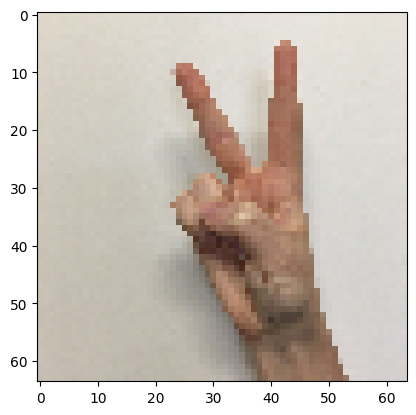

In [18]:
img_path = 'images/my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
x2 = x
print('Input image shape:', x.shape)
imshow(img)
prediction = pre_trained_model.predict(x2)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", prediction)
print("Class:", np.argmax(prediction))

In [28]:
pre_trained_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 32, 32, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 32, 32, 64)   256         ['conv2d_7[0][0]']               
                                                                                           